In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import requests 
import os 
import datetime
from scipy import stats
import netCDF4 as nc
import scipy.optimize as opt
from mpl_toolkits.basemap import Basemap

In [7]:
stn_coord=pd.read_csv('../data/observation/coords.csv')
stn=stn_coord['stn']
stn_lat=stn_coord['lat']
stn_lon=stn_coord['lon']

In [8]:
# Daily visibility data for 47 stations in Nigeria from Dec 2021 to Mar 2022
vis=pd.read_csv('../data/observation/vis_12_2021_03_2022.csv', index_col=[0])
vis.index=pd.to_datetime(vis.index, format='%d/%m/%Y')
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,13.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,16.0,6.0,20.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,20.0,7.0,NaN,10.0,20.0,20.0,1.0,3.0,NaN
2021-12-03,10.0,13.0,3.0,13.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,20.0,3.0,15.0,7.0,20.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,12.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,15.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [9]:
# cap visibility maximum to 10km
# training set from Dec 2021 to Jan 2022, possible to add Feb?, validation for Mar??
vis.columns
for i in vis.columns:
    vis[i]=np.where(vis[i]>10, 10, vis[i])
vis_train=vis.iloc[:90]
vis_test=vis.iloc[90:]
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,10.0,6.0,10.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,10.0,7.0,NaN,10.0,10.0,10.0,1.0,3.0,NaN
2021-12-03,10.0,10.0,3.0,10.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,10.0,3.0,10.0,7.0,10.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,10.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,10.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [11]:
bsc = xr.open_dataset("../data/models/BSC_DREAM8b_V2/20211201_BSC_DREAM8b_V2.nc")
bsc

<xarray.Dataset>
Dimensions:     (longitude: 500, latitude: 250, level: 24, time: 25)
Coordinates:
  * longitude   (longitude) float32 -63.0 -62.67 -62.33 ... 102.7 103.0 103.3
  * latitude    (latitude) float32 -11.0 -10.67 -10.33 ... 71.33 71.67 72.0
  * level       (level) float32 86.0 275.0 495.0 ... 1.356e+04 1.502e+04
  * time        (time) datetime64[ns] 2021-12-01T12:00:00 ... 2021-12-04T12:0...
Data variables:
    OD550_DUST  (time, latitude, longitude) float32 ...
    SCONC_DUST  (time, latitude, longitude) float32 ...
    LOAD_DUST   (time, latitude, longitude) float32 ...
    EMI_DUST    (time, latitude, longitude) float32 ...
    PM10_DUST   (time, latitude, longitude) float32 ...
Attributes:
    Model:    BSC-DREAM8b.v2 with calibration factor in the output of 2

In [12]:
# ('BSC_DREAM8b_V2', 'SCONC_DUST', (7, 15), 1000000000)

In [13]:
nc_files = os.listdir(f"../data/models/BSC_DREAM8b_V2")
nc_files[0]

'20220105_BSC_DREAM8b_V2.nc'

In [14]:
# sconc_dust #
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("../data/models/BSC_DREAM8b_V2/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.SCONC_DUST.time.to_series()[7]]]
    for i in range(len(stn)):
        day1_bsc = bsc.SCONC_DUST.isel(time = 7).sel(latitude = stn_lat[i], 
                                                     longitude = stn_lon[i], 
                                                     method = 'nearest')*1000000000
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        on = ["stn", "lon", "lat"], 
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

,stn,lon,lat,2022-01-06 09:00:00,2022-02-25 09:00:00,2022-01-07 09:00:00,2022-03-30 09:00:00,2022-02-27 09:00:00,2021-12-03 09:00:00,2021-12-18 09:00:00,...,2022-02-06 09:00:00,2022-03-31 09:00:00,2021-12-16 09:00:00,2022-01-17 09:00:00,2022-02-20 09:00:00,2021-12-27 09:00:00,2022-02-02 09:00:00,2022-02-21 09:00:00,2022-02-22 09:00:00,2022-03-29 09:00:00
0,ABE,3.33,7.20,56.526851,19.659478,3.506644e-06,0.043170,26.823388,3.259104,81.898293,...,77.864200,0.043170,50.415540,2.460696,7.216542,28.714194,102.995280,12.160597,26.468353,0.043170
1,ABK,8.19,6.25,80.737827,55.702468,9.675869e-03,0.001160,68.733435,8.917035,168.110944,...,181.494713,0.001160,142.117486,0.473354,46.531301,21.910017,118.576750,181.689387,106.928923,0.001160
2,ABU,7.20,9.00,89.385509,69.796457,1.850327e-04,2.241252,127.187747,143.339818,140.185051,...,169.471832,2.241252,124.641360,48.666934,106.944348,107.221318,164.299735,200.997633,161.170121,2.241252
3,ADO,5.20,7.60,121.044906,69.975201,9.603948e-04,0.003278,31.402713,64.132877,122.444931,...,126.524512,0.003278,87.996206,13.253172,22.438442,85.967898,139.726595,77.093482,179.642967,0.003278
4,AKU,5.30,7.20,98.503733,54.773750,5.768263e-05,0.005334,29.597000,32.251602,99.195674,...,93.954341,0.005334,70.279519,4.873637,20.624912,64.179972,122.303774,42.078419,124.918358,0.005334
5,ASA,6.23,6.82,47.767809,27.370692,6.476084e-05,0.029034,20.231147,8.728993,87.172381,...,107.473532,0.029034,35.674184,0.922048,19.719245,32.185245,92.222422,14.891183,28.085420,0.029034
6,AWK,7.07,6.20,57.857271,30.428250,1.293431e-03,0.033133,19.083821,5.577502,105.708232,...,180.809863,0.033133,55.308412,0.652470,18.372759,24.601382,85.737582,49.493000,31.835437,0.033133
7,BAU,9.82,10.28,104.169779,227.530307,2.498520e-01,72.389852,227.068000,267.254649,303.187022,...,335.763673,72.389852,339.845883,146.678786,503.892011,198.483335,402.970500,312.418507,256.318117,72.389852
8,BEN,5.60,6.33,21.049184,10.245316,5.666112e-04,0.009924,11.968222,2.705962,28.740239,...,44.235840,0.009924,21.835747,0.134705,13.328512,19.335451,88.455756,10.935111,7.652988,0.009924
9,BID,6.00,9.80,111.894408,75.549913,1.404567e-02,3.707580,157.966213,185.337257,168.312894,...,257.679659,3.707580,191.356293,93.864593,189.686375,148.248361,261.669811,291.259937,215.619337,3.707580


In [15]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()

day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d")
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t.head()

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
index,,,,,,,,,,,,,,,,,,,,,
2022-01-06,56.526851,80.737827,89.385509,121.044906,98.503733,47.767809,57.857271,104.169779,21.049184,111.894408,...,171.044576,143.672139,191.050816,48.540112,7.258729,3.100856,142.427922,2.343661,64.827915,93.092318
2022-02-25,19.659478,55.702468,69.796457,69.975201,54.77375,27.370692,30.42825,227.530307,10.245316,75.549913,...,492.105983,58.355756,82.739177,32.267824,6.907768,4.295815,77.896033,6.461318,140.606133,125.174154
2022-01-07,0.000004,0.009676,0.000185,0.00096,0.000058,0.000065,0.001293,0.249852,0.000567,0.014046,...,1.610366,0.000133,0.409638,0.000075,0.0,0.00394,0.053086,0.000066,0.119683,0.067509
2022-03-30,0.04317,0.00116,2.241252,0.003278,0.005334,0.029034,0.033133,72.389852,0.009924,3.70758,...,187.477767,0.029367,45.396554,0.006184,0.000394,0.014667,6.922037,0.000695,14.887435,70.523704
2022-02-27,26.823388,68.733435,127.187747,31.402713,29.597,20.231147,19.083821,227.068,11.968222,157.966213,...,243.247513,38.512933,249.743749,24.404464,5.486683,6.374613,199.23543,7.95651,155.232769,215.790806


/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  r

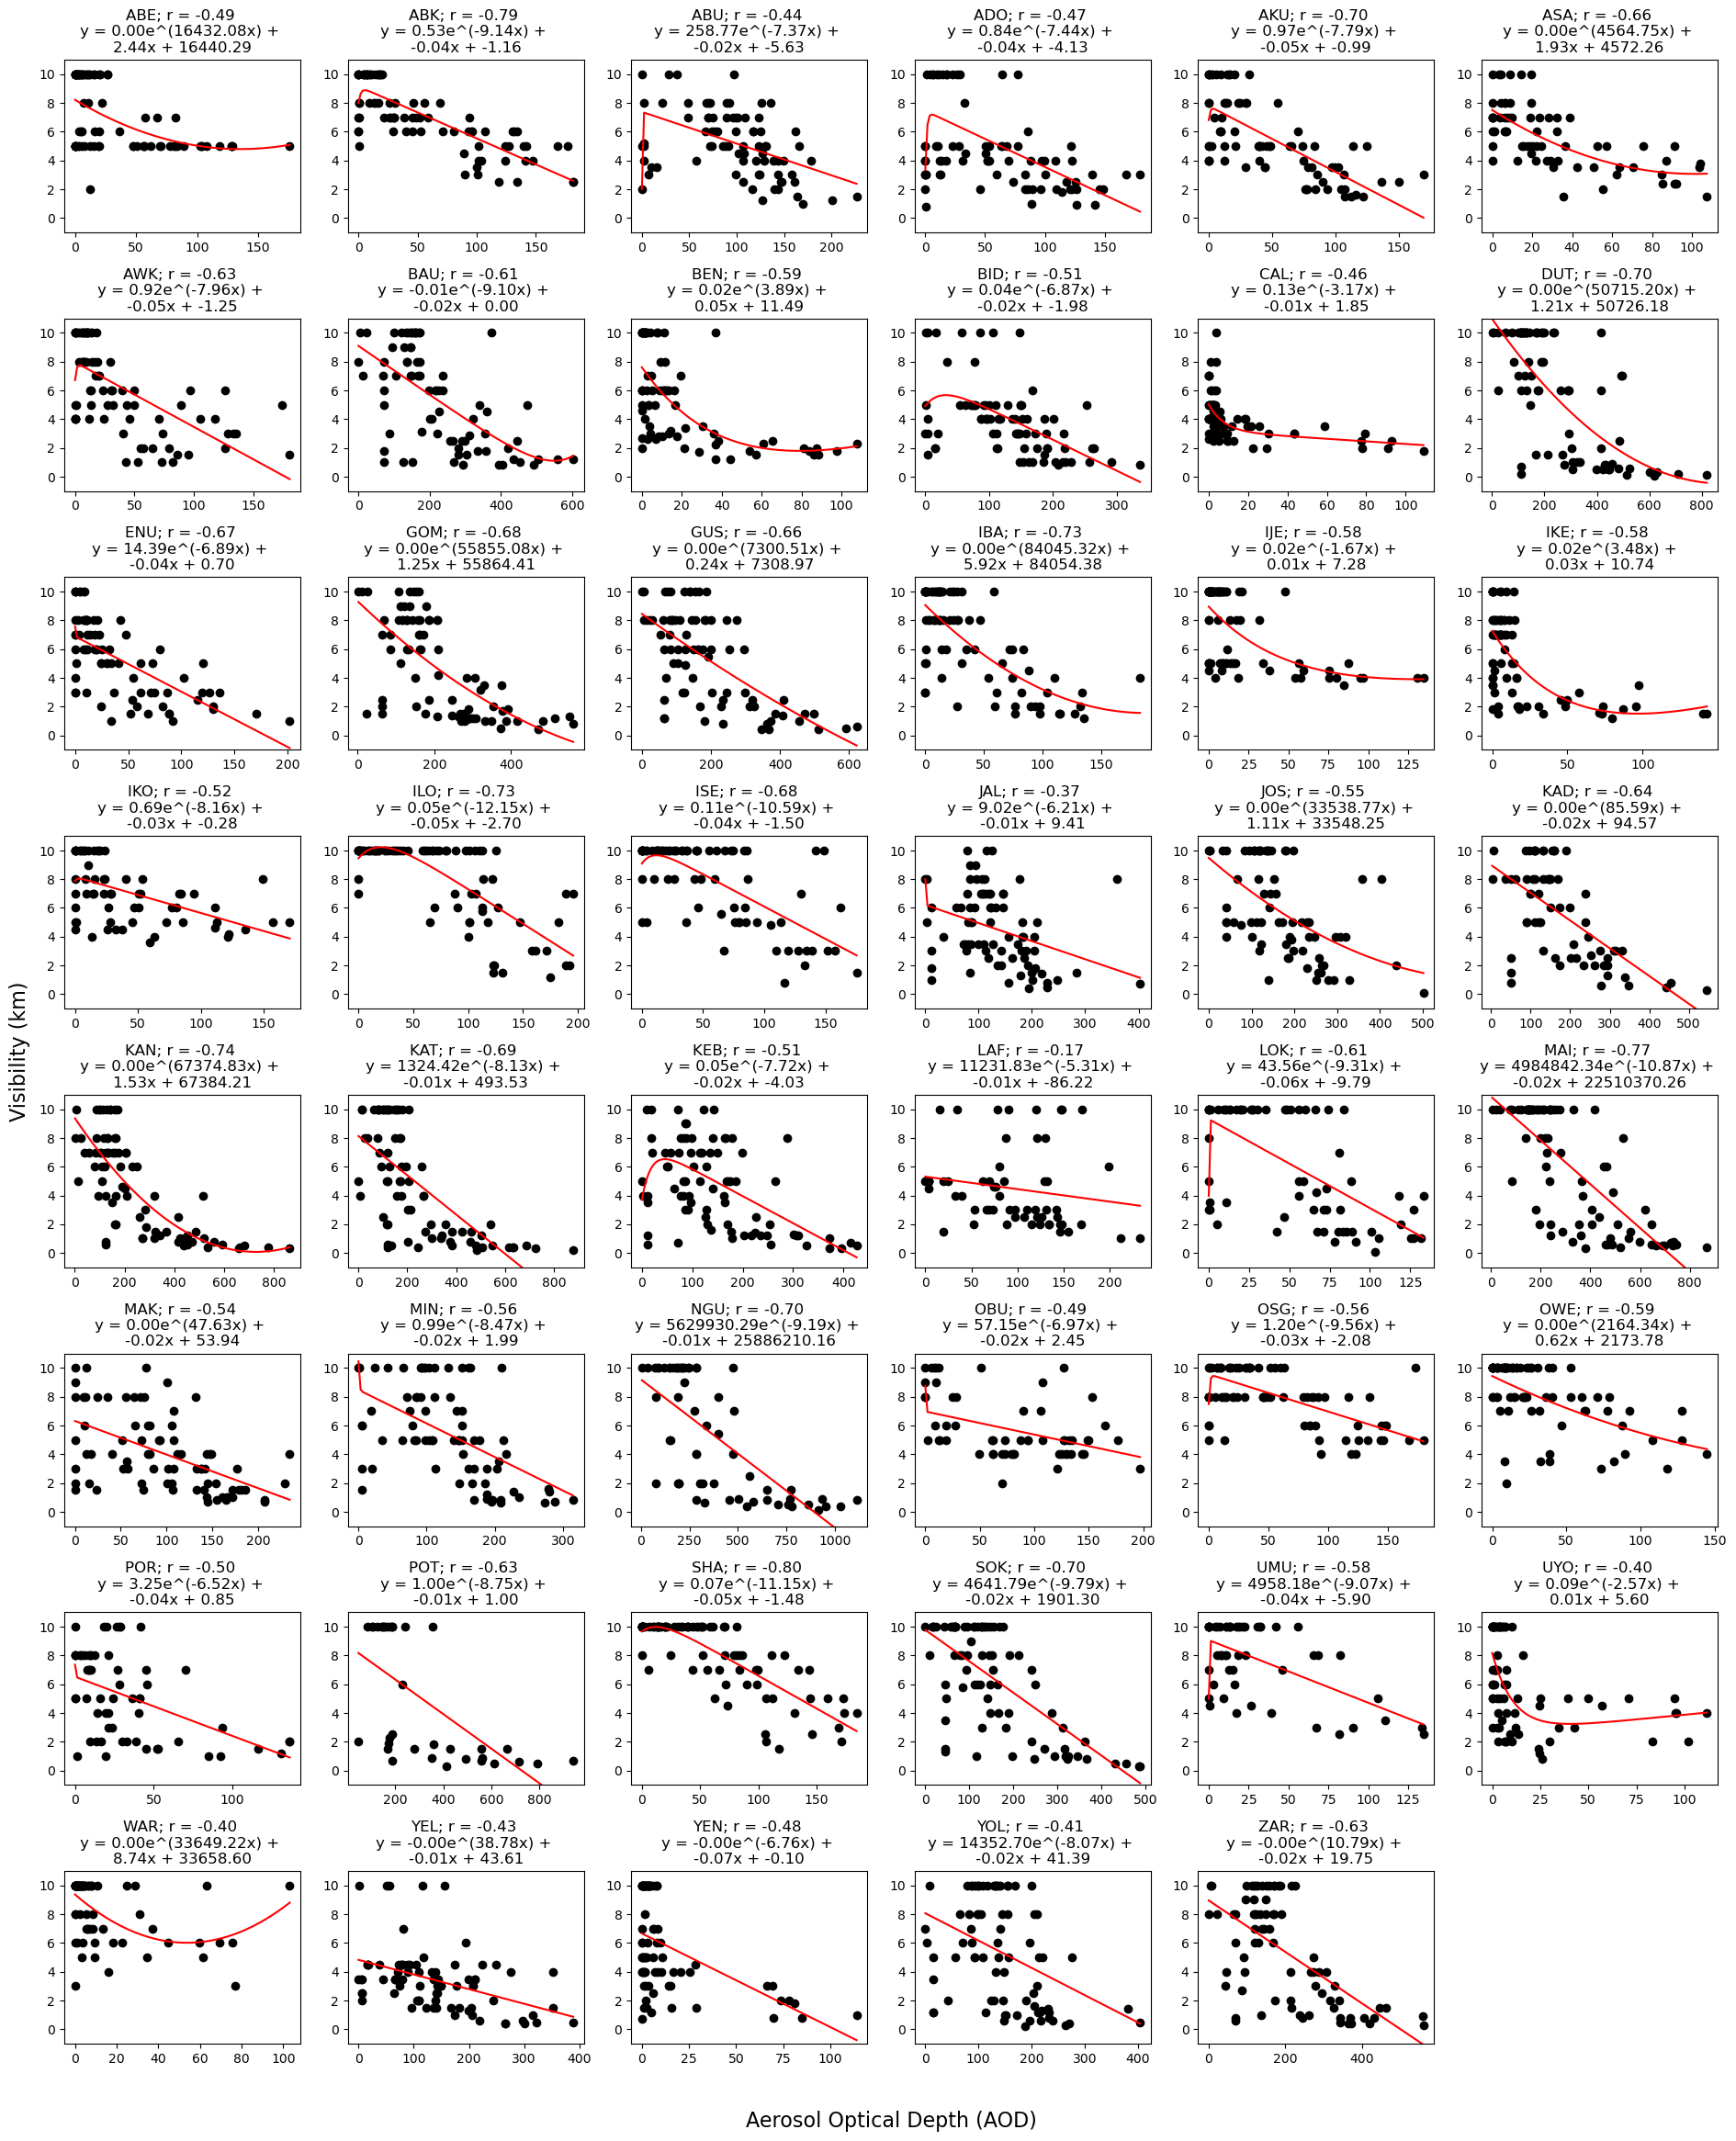

In [16]:
cor_ls = []

fig = plt.figure(figsize=(20, 24))

def exp_func(x, a, b, c, d):
    return a * np.exp(-b * x) + c + d*x

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    merged['AOD'] = pd.to_numeric(merged['AOD'], errors='coerce') # convert to numeric type
    ab = merged.dropna()

    # exponential regression part
    popt, pcov = opt.curve_fit(exp_func, ab['AOD'], ab['Visibility'], maxfev=10000)
    exp_fit = exp_func(ab['AOD'], *popt)

    # calculate correlation
    corr = np.corrcoef(ab['AOD'], ab['Visibility'])[0,1]
    p_val = stats.pearsonr(ab['AOD'], ab['Visibility'])[1]

    cor_ls.append([stn_lat[i], stn_lon[i], j, round(corr, 2), round(p_val, 2)])

    ax = fig.add_subplot(8,6,i+1)
    ax.scatter(ab['AOD'], ab['Visibility'], color='k')
    
    x_fitted = np.linspace(np.min(ab['AOD']), np.max(ab['AOD']), 100)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    d = popt[3]
    y_fitted = a * np.exp(-b * x_fitted) + c + d*x_fitted
    
    ax.plot(x_fitted, y_fitted, 'r')
#     title = j + '\n a={:.2f}, b={:.2f}, c={:.2f}, d={:.2f}\n'.format(*popt) + 'corr={:.2f}, p-value={:.2f}'.format(corr, p_val)
#     ax.set_title(title, fontsize=14)
    ax.set_ylim([-1, 11])
    ax.margins(y=0.2)
    
#     ax.set_xlim([0, 1.5])
#     ax.set_ylim([-1, 11])
#     ax.margins(x=0.05, y=0.2)
    equation = j + '; ' + f'r = {corr:.2f} \n' + f'y = {popt[1]:.2f}e^({-popt[2]:.2f}x) + \n{popt[3]:.2f}x + {popt[0]:.2f}'

#     ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(equation, fontsize=12)


plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.95, bottom=0.05, left=0.05, right=0.95)
# fig.suptitle('Relationship Between Aerosol Optical Depth (AOD) and Visibility', fontsize=20)
fig.supxlabel('Aerosol Optical Depth (AOD)', fontsize=16)
fig.supylabel('Visibility (km)', fontsize=16)
plt.savefig('../plots/day1/BSC_DREAM8b_V2.png')

In [17]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
# cor_df

# cor_df.to_csv("cor_files/day1/MULTI MODEL MEDIAN_1d.csv", index=False)
cor_df.to_csv("../plots/day1/BSC_DREAM8b_V2.csv", index=False)
# cor_df.to_csv("cor_files/day3/MULTI MODEL MEDIAN_3d.csv", index=False)